# Tabular reinforcement learning lab notebook

## Students involved :
- Paul PHILIPPE - 21112687: paul-etienne.philippe@etu.sorbonne-universite.fr
- William WU - 21107936: william.wu@etu.sorbonne-universite.fr

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [ ]:
%pip install -q swig==4.3.1


%pip install -q bbrl-utils==1.1.0
%pip install -q gymnasium[mujoco]==1.2.0
%pip install -q mazemdp==1.2.12


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.3/944.3 kB 12.4 MB/s eta 0:00:00


In [ ]:
try:
    # Allows to enable custom widgets
    from google.colab import output

    output.enable_custom_widget_manager()
except ModuleNotFoundError:
    pass

# Outlook

In this notebook we will study basic reinforcement learning
algorithms: TD learning, Q-learning and SARSA. We will also investigate two
basic exploration strategies: $\epsilon$-greedy and softmax.


## Initialization

We begin by loading all the modules necessary for this notebook.

In [ ]:
from mazemdp import random_policy
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp.mdp import Mdp  # noqa: F401
from bbrl_utils.notebook import tqdm
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from typing import List, Tuple
import os

import bbrl_utils

from typing import List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from bbrl_utils.notebook import tqdm
from mazemdp.mdp import Mdp  # noqa: F401
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy
import bbrl_gymnasium  # noqa: F401

bbrl_utils.setup()

Matplotlib backend: module://matplotlib_inline.backend_inline


/usr/local/lib/python3.12/dist-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  m

# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

In [ ]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
mdp = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0, "start_states": [0]},
    render_mode="human",
)
mdp.reset()
mdp.unwrapped.init_draw("The maze")

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

# Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations:

$$\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1})-V^{(i)}(s_t)$$
$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

Note however that when the episode terminates in state $s_t$,
back-propagating the value of $s_{t+1}$ makes no sense,
as the environment will be reset for the next episode.
So, in such a case, we should ignore the $\gamma V^{(i)}(s_{t+1})$ term.
We could write this with if terminated: $\delta_t = r(s_t,a_t) -V^{(i)}(s_t)$ else standard update,
but since the `terminated` boolean can be seen as an integer,
we can obtain the same behaviour with $\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1}) (1 - terminated) - V^{(i)}(s_t)$.

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

The ```evaluate``` function below is not necessary for the lab, it is left here for its informative value.

In [ ]:
def evaluate(mdp, policy):
    s, _ = mdp.reset(options={"uniform": True})
    terminated = False
    truncated = False
    reward = 0

    while not (terminated or truncated):
        # Perform a step of the MDP
        a = sample_categorical(policy[s])
        _, r, terminated, truncated, *_ = mdp.step(a)
        reward += r
    return reward

**Question:** In the code of the *temporal_difference(...)* function below,
fill the missing parts

In [ ]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2, # alpha: learning rate
    render: bool = True,
) -> np.ndarray:
    env = mdp.unwrapped

    v = np.zeros(env.nb_states)  # initial state value v

    if render:
        env.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode
        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        s, _ = mdp.reset(options={"uniform": True})
        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show agent
            if render:
                env.draw_v_pi(v, policy)

            # Step forward following the MDP: s=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], terminated=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, terminated, truncated, _ = mdp.step(
                egreedy_loc(policy[s], env.action_space.n, epsilon=0.2)
            )

            # If terminated, there's no next state value
            if terminated:
                target = r
            else:
                # Reward + value of next state
                target = r + v[y]

            # Update the state value of x
            delta = target - v[s]
            v[s] = v[s] + alpha * delta

            # Update agent's position (state)
            s = y

    if render:
        env.current_state = 0
        env.draw_v_pi(v, policy)
    return v

Once this is done, you can run it.

In [ ]:
policy = random_policy(mdp.unwrapped)
v = temporal_difference(mdp, policy, nb_episodes=10)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

  0%|          | 0/10 [00:00<?, ?it/s]

Unless you were lucky, the generated value function is boring: if the policy
does not reach the final state, all values are 0. To avoid this, you can
copy-paste a dynamic programming function on the Q function from the previous
notebook, use it to get an optimal policy, and use this policy for TD
learning. You should get a much more interesting value function.

In [ ]:
# Put your code to obtain an optimal Q function here

# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function

def value_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    mdp.init_draw("Value iteration Q")

    mdp.draw_v(q)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q)

        for s in range(mdp.nb_states):
            for a in range(mdp.action_space.n):
                if s in mdp.terminal_states:
                    q[s, a] = mdp.r[s, a]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[s, a, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus
                    q[s, a] = mdp.r[s, a] + mdp.gamma * summ


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q)

    return q, q_list

q, q_list = value_iteration_q(mdp.unwrapped, render=True)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

In [ ]:
# Put your code to get a policy from a Q function here

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

policy_optimal = get_policy_from_q(q)

In [ ]:
# Put your code to run the algorithm here

v = temporal_difference(mdp, policy_optimal, nb_episodes=10)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

  0%|          | 0/10 [00:00<?, ?it/s]

# Q-learning ##

The **Q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(i)}(s_{t+1},a) \right) -Q^{(i)}(s_t,a_t)
$$

$$Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

Fill the code of the `q_learning(...)` function below.

In [ ]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps(
    mdp: MazeMDPEnv,
    alpha: float = 0.2, # alpha is the learning rate
    epsilon: float = 0.02,
    nb_episodes: int = 20,
    render: bool = True,
    init_q: float = 0.0,
    uniform: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Run learning cycle
    env = mdp.unwrapped

    # Initialize the state-action value function

    q = np.zeros((env.nb_states, env.action_space.n))
    q_min = np.zeros((env.nb_states, env.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []


    if render:
        env.init_draw("Q Learning")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s, _ = mdp.reset(options={"uniform": uniform})
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                env.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            a = egreedy(q, s, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(a)

            # [[STUDENT]]...

            if terminated:
                target = r
            else:
                target = r + mdp.gamma * np.max(q[y, :])

            # Update the state-action value function with q-Learning
            delta = target - q[s, a]
            q[s, a] = q[s, a] + alpha * delta

            # Update the agent position
            s = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        env.current_state = 0
        env.draw_v_pi(q, get_policy_from_q(q))

    return q_list, time_list

And run it.

In [ ]:
alpha = 0.5
epsilon = 0.02
MAX_EPISODES = 100
q_list, time_list = q_learning_eps(mdp.unwrapped, alpha, epsilon, nb_episodes=MAX_EPISODES)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell.

In [ ]:
alpha = 0.5
epsilon = 0.02
start_q_list, time_list = q_learning_eps(
    mdp, alpha, epsilon, nb_episodes=MAX_EPISODES, uniform=False
)

You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

In [ ]:
# Use different initialization: set initial Q-values to a small positive value that is lower than the final reward but encourages exploration

init_q_value = 0.1
start_q_list, time_list = q_learning_eps(
    mdp.unwrapped,
    alpha,
    epsilon,
    nb_episodes=MAX_EPISODES,
    uniform=False,
    init_q=init_q_value
)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*.

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`mazemdp.toolbox`.

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

In [ ]:
# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate

def q_learning_soft(
    mdp: MazeMDPEnv,
    alpha: float = 0.2, # alpha: learning rate
    beta: float = 0.6,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Run learning cycle
    env = mdp.unwrapped

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((env.nb_states, env.action_space.n))
    q_min = np.zeros((env.nb_states, env.action_space.n))
    q_list = []
    time_list = []

    if render:
        env.init_draw("Q Learning (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s, _ = mdp.reset(options={"uniform": True})
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                env.draw_v_pi(q, q.argmax(axis=1))

            # [[STUDENT]]...

            # Draw an action using a soft-max policy

            a = sample_categorical(softmax(q, s, beta))

            # [[STUDENT]]...

            # Copy-paste the rest from q_learning_eps

            y, r, terminated, truncated, _ = mdp.step(a)
            if terminated:
                target = r
            else:
                target = r + mdp.gamma * np.max(q[y, :])
            delta = target - q[s, a]
            q[s, a] = q[s, a] + alpha * delta

            s = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        env.current_state = 0
        env.draw_v_pi(q, get_policy_from_q(q))

    return q_list, time_list

 Run this new version

In [ ]:
NB_EPISODES = 40
alpha = 0.5
beta = 0.16
q_list, time_list = q_learning_soft(mdp.unwrapped, alpha, beta, nb_episodes=MAX_EPISODES)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

# Sarsa

The **SARSA** algorithm is very similar to **Q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**SARSA**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

The update formula is as follows:

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1})
\right) -Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$


## SARSA ($\epsilon-greedy$ version)
Fill the code below

In [ ]:
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def sarsa_eps(
    mdp: MazeMDPEnv,
    alpha: float = 0.2, # alpha is the learning rate
    epsilon: float = 0.02,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Run learning cycle
    env = mdp.unwrapped

    # Initialize the state-action value function
    q = np.zeros((env.nb_states, env.action_space.n))
    q_min = np.zeros((env.nb_states, env.action_space.n))
    q_list = []
    time_list = []

    if render:
        env.init_draw("SARSA e-greedy")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s, _ = mdp.reset(options={"uniform": True})
        cpt = 0

        # [[STUDENT]]...

        # Choose first action using epsilon-greedy policy
        a = egreedy(q, s, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                env.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP with current action
            s_next, r, terminated, truncated, _ = mdp.step(a)

            # Choose next action using epsilon-greedy policy
            a_next = egreedy(q, s_next, epsilon)

            if terminated:
                target = r
            else:
                target = r + mdp.gamma * q[s_next, a_next]

            delta = target - q[s, a]
            q[s, a] = q[s, a] + alpha * delta

            # Update state and action for next iteration
            s = s_next
            a = a_next
            cpt = cpt + 1


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        env.current_state = 0
        env.draw_v_pi(q, get_policy_from_q(q))
    return q_list, time_list

And run it.

In [ ]:
learning_rate = 0.5
alpha = 0.5
epsilon = 0.02
q_list, time_list = sarsa_eps(mdp.unwrapped, alpha, epsilon, nb_episodes=MAX_EPISODES)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

As for **Q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [ ]:
# --------------------------- SARSA, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def sarsa_soft(
    mdp: MazeMDPEnv,
    alpha: float = 0.2, # alpha is the learning rate
    beta: float = 0.6,
    nb_episodes: int = 20,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Run learning cycle
    env = mdp.unwrapped

    # Initialize the state-action value function

    q = np.zeros((env.nb_states, env.action_space.n))
    q_min = np.zeros((env.nb_states, env.action_space.n))
    q_list = []
    time_list = []

    if render:
        env.init_draw("SARSA (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s, _ = mdp.reset(options={"uniform": True})
        cpt = 0

        # [[STUDENT]]...

        # Choose first action using softmax policy

        a = sample_categorical(softmax(q, s, beta))
        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                env.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP with current action
            s_next, r, terminated, truncated, _ = mdp.step(a)

            # Choose next action using softmax policy
            action_probs_next = softmax(q, s_next, beta)
            a_next = sample_categorical(action_probs_next)

            if terminated:
                target = r
            else:
                target = r + mdp.gamma * q[s_next, a_next]

            delta = target - q[s, a]
            q[s, a] = q[s, a] + alpha * delta

            # Update state and action for next iteration
            s = s_next
            a = a_next
            cpt = cpt + 1


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        env.current_state = 0
        env.draw_v_pi(q, get_policy_from_q(q))
    return q_list, time_list

And run it.

In [ ]:
alpha = 0.5
beta = 0.6

q_list, time_list = sarsa_soft(mdp.unwrapped, alpha, beta, nb_episodes=MAX_EPISODES)

       [ 1,  4,  5,  8],
       [ 2, -1,  6,  9]]), t…

## Impact of `epsilon` and `temperature` on Q-learning and SARSA

Compare the number of steps needed by **Q-learning** and **SARSA** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, alpha, epsilon,
beta, nb_episodes, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome, e.g. a heat map, see below.

In [ ]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(mdp, alpha,  epsilon, beta, nb_episodes, render):
    q_list1, time_list1 = q_learning_eps(mdp, alpha,  epsilon, nb_episodes, render)
    q_list2, time_list2 = q_learning_soft(mdp, alpha,  beta, nb_episodes, render)
    q_list3, time_list3 = sarsa_eps(mdp, alpha,  epsilon, nb_episodes, render)
    q_list4, time_list4 = sarsa_soft(mdp, alpha,  beta, nb_episodes, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="Q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="Q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="SARSA e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="SARSA softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="SARSA e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="SARSA softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

Example 1: Very low exploration


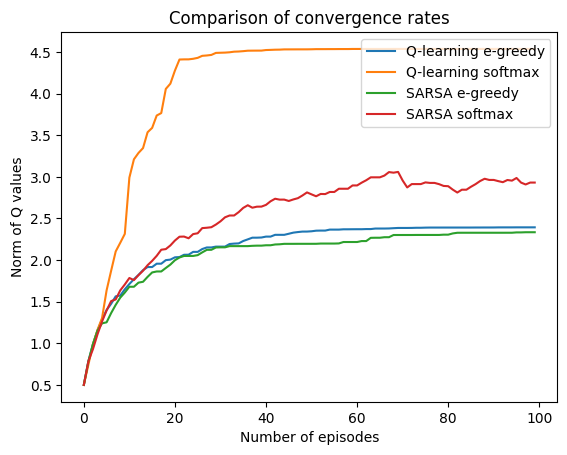

<Figure size 640x480 with 0 Axes>

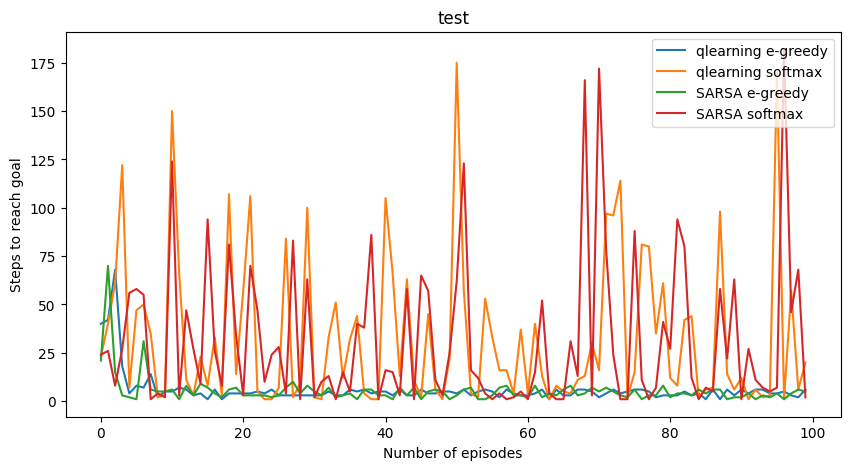

In [ ]:
# Example 1: Very low exploration (greedy behavior)
print("Example 1: Very low exploration")
plot_ql_sarsa(
    mdp.unwrapped,
    alpha = 0.5,
    epsilon=0.001,
    beta=10.0,
    nb_episodes=MAX_EPISODES,
    render=False
)


Example 2: Moderate exploration


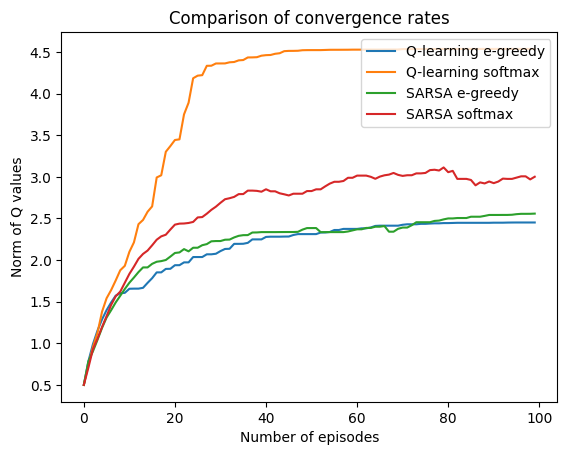

<Figure size 640x480 with 0 Axes>

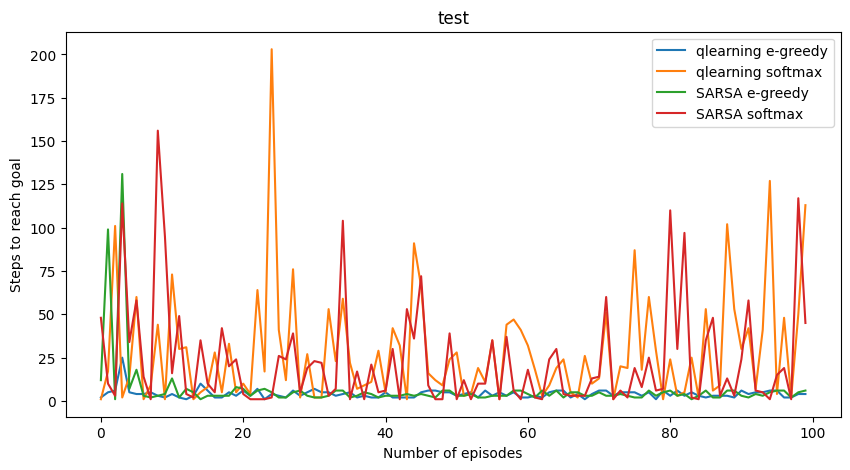

In [ ]:
# Example 2: Moderate exploration
print("Example 2: Moderate exploration")
plot_ql_sarsa(
    mdp.unwrapped,
    alpha = 0.5,
    epsilon=0.02,
    beta=1.0,
    nb_episodes=MAX_EPISODES,
    render=False
)


Example 3: High exploration


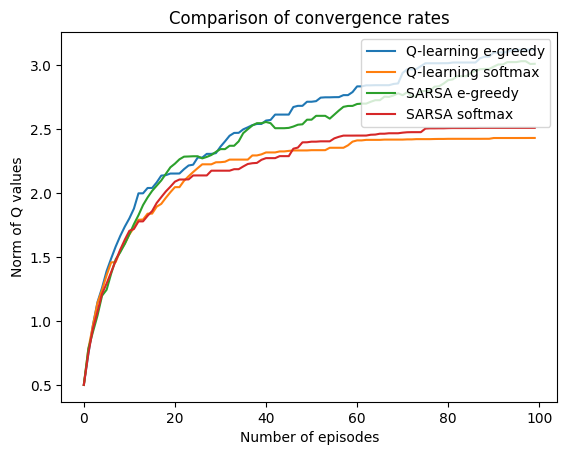

<Figure size 640x480 with 0 Axes>

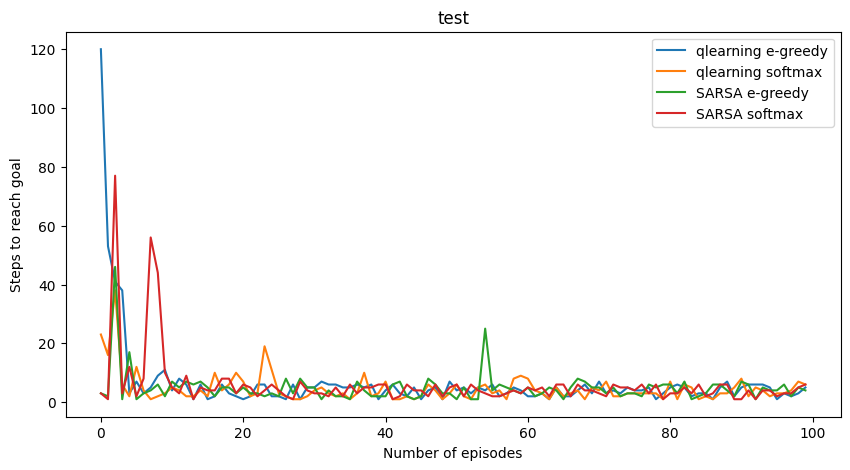

In [ ]:
# Example 3: High exploration
print("Example 3: High exploration")
plot_ql_sarsa(
    mdp.unwrapped,
    alpha = 0.5,
    epsilon=0.1,
    beta=0.1,
    nb_episodes=MAX_EPISODES,
    render=False
)


Example 4: Very high exploration


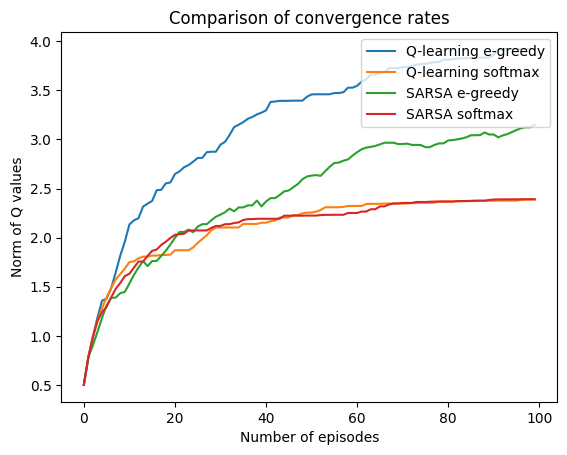

<Figure size 640x480 with 0 Axes>

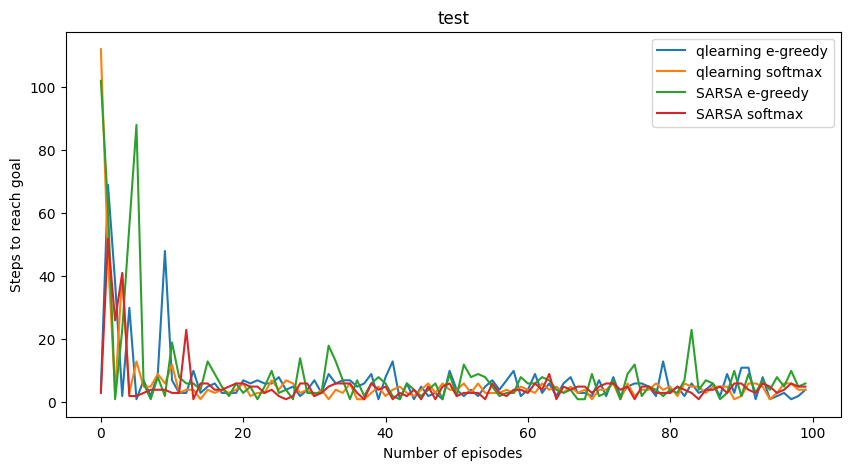

In [ ]:
# Example 4: Very high exploration (almost random)
alpha = 0.5
print("Example 4: Very high exploration")
plot_ql_sarsa(
    mdp.unwrapped,
    alpha = 0.5,
    epsilon=0.3,
    beta=0.01,
    nb_episodes=MAX_EPISODES,
    render=False
)


Example 5: Balanced parameters


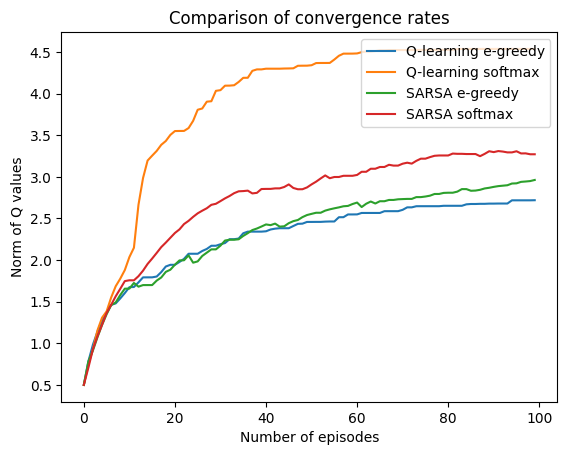

<Figure size 640x480 with 0 Axes>

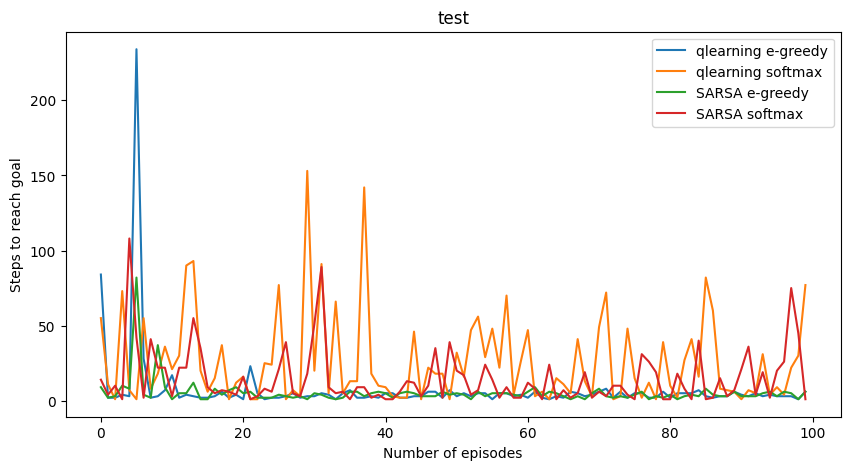

In [ ]:
# Example 5: Balanced parameters
print("Example 5: Balanced parameters")
plot_ql_sarsa(
    mdp.unwrapped,
    alpha = 0.5,
    epsilon=0.05,
    beta=0.5,
    nb_episodes=MAX_EPISODES,
    render=False
)


## Commenting graphs

#### 1. Key observations

**About convergence patterns:**
- For low exploration parameters, the convergence is fast but unstable
- For high exploration parameters, the convergence is slow but stable  
- For moderate exploration parameters, the convergence achieves optimal balance

**About the algorithm's performance:**
- For Q-learning, the learning is faster but more variable due to off-policy nature
- For SARSA, the learning is more conservative but robust due to on-policy approach
- For both algorithms, insufficient exploration leads to local optima convergence

#### 2. Parameters analysis

**Epsilon (ε-greedy):**
- For very low epsilon values (0.001), the behavior is nearly greedy with premature convergence risk
- For moderate epsilon values (0.01-0.1), the exploration-exploitation trade-off is balanced
- For high epsilon values (>0.2), the excessive exploration slows learning significantly

**Beta (softmax):**
- For low beta values (<0.1), the exploration approaches uniform random selection
- For moderate beta values (0.5-2.0), the action selection adapts to value estimates
- For high beta values (>5.0), the behavior becomes nearly deterministic

#### 3. Final Conclusions

The given results demonstrate that exploration parameters critically influence learning performance. Moderate values for both epsilon (0.01-0.1) and beta (0.5-2.0) provide the optimal balance between convergence speed and stability. Algorithm selection should be guided by application priorities: Q-learning for faster learning where variability is acceptable, and SARSA for more robust performance in conservative settings.

### Effect of hyper-parameters

The other two hyper-parameters of **Q-learning** and **SARSA** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval.
Make sure that your figure complies with [The figure checklist](https://master-dac.isir.upmc.fr/The_figure_checklist.pdf).

=== Q-learning Hyperparameter Analysis ===
Analyzing q_learning hyperparameters...


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


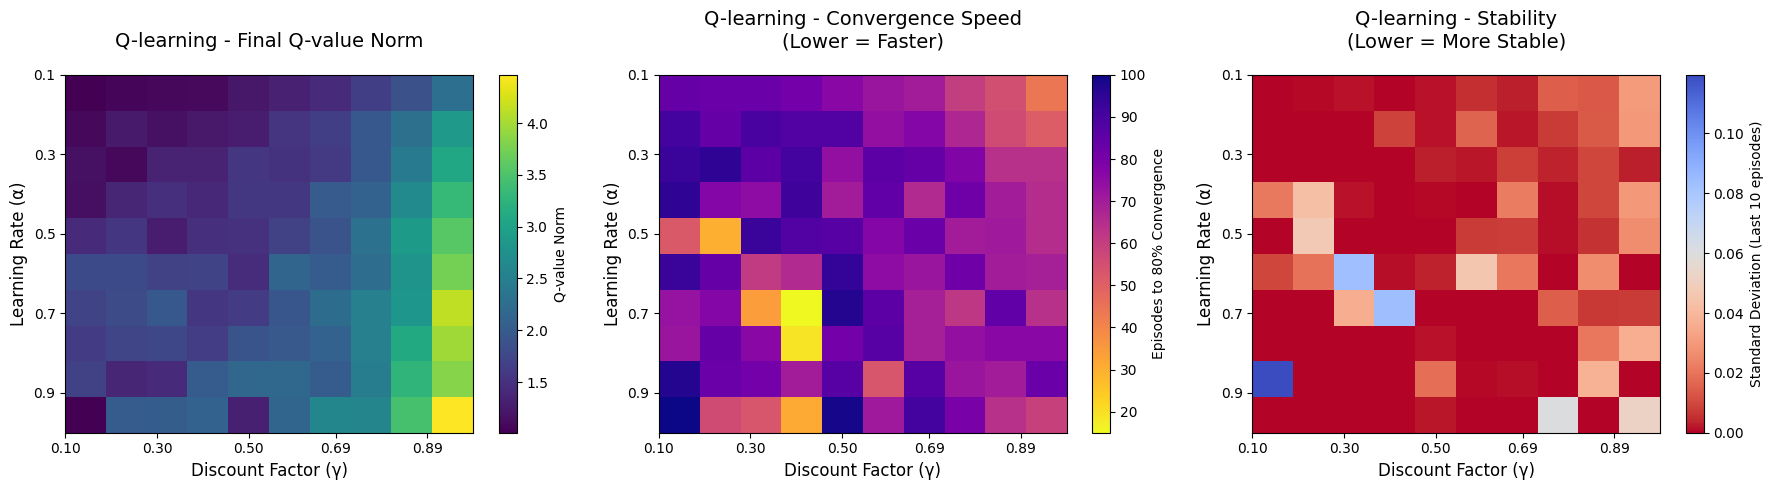


=== SARSA Hyperparameter Analysis ===
Analyzing sarsa hyperparameters...


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


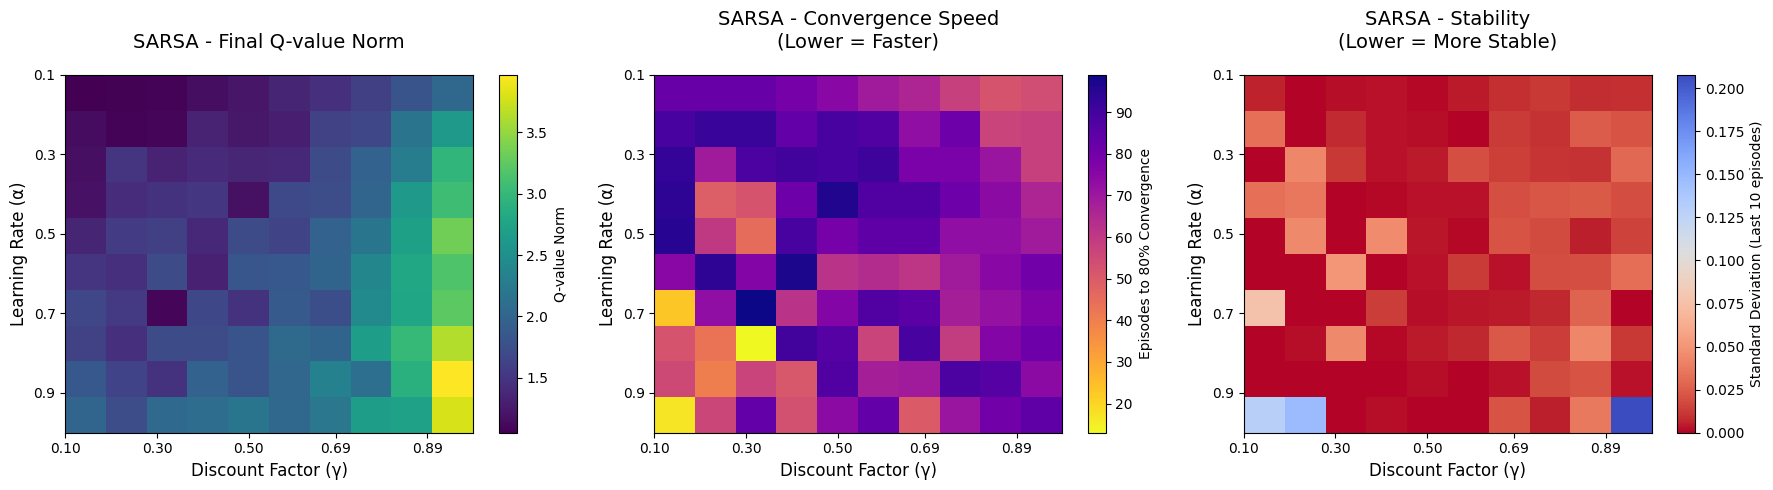


=== Extreme Parameter Learning Curves ===


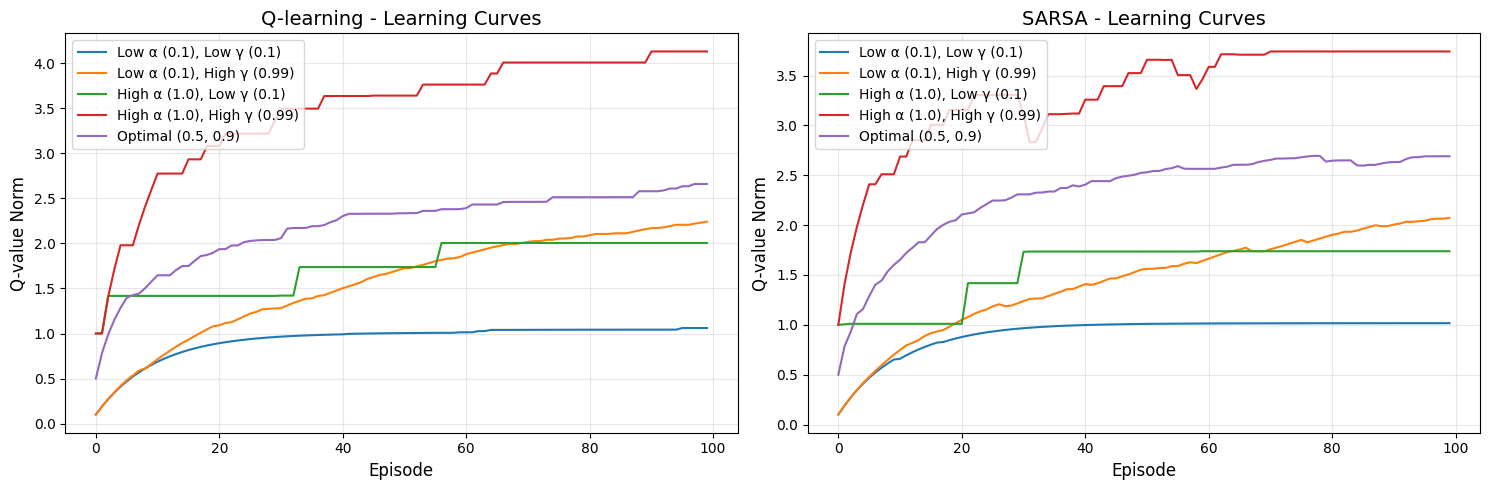

In [ ]:
def analyze_hyperparameters(mdp, algorithm='q_learning', nb_episodes=100):
    """
    Analyze the effect of alpha and gamma hyperparameters on learning performance
    """
    # Define parameter ranges
    alphas = np.linspace(0.1, 1.0, 10)  # Learning rates
    gammas = np.linspace(0.1, 0.99, 10)  # Discount factors

    # Initialize results matrices
    final_performance = np.zeros((len(alphas), len(gammas)))
    convergence_speed = np.zeros((len(alphas), len(gammas)))
    stability = np.zeros((len(alphas), len(gammas)))

    # Fixed exploration parameters
    epsilon = 0.05
    beta = 1.0

    print(f"Analyzing {algorithm} hyperparameters...")

    for i, alpha in enumerate(tqdm(alphas)):
        for j, gamma in enumerate(gammas):
            # Set the gamma parameter in the MDP
            mdp.unwrapped.gamma = gamma

            # Run the selected algorithm
            if algorithm == 'q_learning':
                q_list, time_list = q_learning_eps(mdp.unwrapped, alpha, epsilon, nb_episodes, render=False)
            elif algorithm == 'sarsa':
                q_list, time_list = sarsa_eps(mdp.unwrapped, alpha, epsilon, nb_episodes, render=False)
            else:
                raise ValueError("Algorithm must be 'q_learning' or 'sarsa'")

            # Performance metrics
            final_performance[i, j] = q_list[-1] if len(q_list) > 0 else 0
            convergence_speed[i, j] = len(q_list) - np.argmax(q_list > 0.8 * q_list[-1]) if len(q_list) > 0 else nb_episodes
            stability[i, j] = np.std(q_list[-10:]) if len(q_list) >= 10 else 1.0

    return alphas, gammas, final_performance, convergence_speed, stability

def plot_hyperparameter_heatmaps(alphas, gammas, final_performance, convergence_speed, stability, algorithm_name):
    """
    Create publication-quality heatmaps for hyperparameter analysis
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Final Performance
    im1 = axes[0].imshow(final_performance, cmap='viridis', aspect='auto',
                        extent=[gammas[0], gammas[-1], alphas[-1], alphas[0]])
    axes[0].set_xlabel('Discount Factor (γ)', fontsize=12)
    axes[0].set_ylabel('Learning Rate (α)', fontsize=12)
    axes[0].set_title(f'{algorithm_name} - Final Q-value Norm', fontsize=14, pad=20)
    plt.colorbar(im1, ax=axes[0], label='Q-value Norm')

    # Plot 2: Convergence Speed
    im2 = axes[1].imshow(convergence_speed, cmap='plasma_r', aspect='auto',
                        extent=[gammas[0], gammas[-1], alphas[-1], alphas[0]])
    axes[1].set_xlabel('Discount Factor (γ)', fontsize=12)
    axes[1].set_ylabel('Learning Rate (α)', fontsize=12)
    axes[1].set_title(f'{algorithm_name} - Convergence Speed\n(Lower = Faster)', fontsize=14, pad=20)
    plt.colorbar(im2, ax=axes[1], label='Episodes to 80% Convergence')

    # Plot 3: Stability
    im3 = axes[2].imshow(stability, cmap='coolwarm_r', aspect='auto',
                        extent=[gammas[0], gammas[-1], alphas[-1], alphas[0]])
    axes[2].set_xlabel('Discount Factor (γ)', fontsize=12)
    axes[2].set_ylabel('Learning Rate (α)', fontsize=12)
    axes[2].set_title(f'{algorithm_name} - Stability\n(Lower = More Stable)', fontsize=14, pad=20)
    plt.colorbar(im3, ax=axes[2], label='Standard Deviation (Last 10 episodes)')

    # Add grid for better readability
    for ax in axes:
        ax.grid(False)
        ax.set_xticks(np.round(gammas[::2], 2))
        ax.set_yticks(np.round(alphas[::2], 1))

    plt.tight_layout()
    plt.show()

    return fig

# Run analysis for both algorithms
print("=== Q-learning Hyperparameter Analysis ===")
alphas_ql, gammas_ql, perf_ql, speed_ql, stab_ql = analyze_hyperparameters(mdp, 'q_learning', 100)
fig_ql = plot_hyperparameter_heatmaps(alphas_ql, gammas_ql, perf_ql, speed_ql, stab_ql, 'Q-learning')

print("\n=== SARSA Hyperparameter Analysis ===")
alphas_sarsa, gammas_sarsa, perf_sarsa, speed_sarsa, stab_sarsa = analyze_hyperparameters(mdp, 'sarsa', 100)
fig_sarsa = plot_hyperparameter_heatmaps(alphas_sarsa, gammas_sarsa, perf_sarsa, speed_sarsa, stab_sarsa, 'SARSA')

# Additional analysis: Learning curves for extreme parameter combinations
def plot_extreme_parameter_curves(mdp, nb_episodes=100):
    """
    Plot learning curves for extreme parameter combinations
    """
    extreme_params = [
        ('Low α (0.1), Low γ (0.1)', 0.1, 0.1),
        ('Low α (0.1), High γ (0.99)', 0.1, 0.99),
        ('High α (1.0), Low γ (0.1)', 1.0, 0.1),
        ('High α (1.0), High γ (0.99)', 1.0, 0.99),
        ('Optimal (0.5, 0.9)', 0.5, 0.9)
    ]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for label, alpha, gamma in extreme_params:
        mdp.unwrapped.gamma = gamma

        # Q-learning
        q_list_ql, _ = q_learning_eps(mdp.unwrapped, alpha, 0.05, nb_episodes, render=False)
        axes[0].plot(q_list_ql, label=f'{label}')

        # SARSA
        q_list_sarsa, _ = sarsa_eps(mdp.unwrapped, alpha, 0.05, nb_episodes, render=False)
        axes[1].plot(q_list_sarsa, label=f'{label}')

    for i, (ax, title) in enumerate(zip(axes, ['Q-learning', 'SARSA'])):
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Q-value Norm', fontsize=12)
        ax.set_title(f'{title} - Learning Curves', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n=== Extreme Parameter Learning Curves ===")
plot_extreme_parameter_curves(mdp)

## Hyperparameter analysis

#### Learning Rate (α) Effect:
- Low α (<0.3): Slow but stable learning, avoids overshooting
- Medium α (0.3-0.7): Balanced learning speed and stability  
- High α (>0.7): Fast initial learning but unstable, may oscillate

#### Discount Factor (γ) Effect:
- Low γ (<0.5): Myopic behavior, ignores long-term rewards
- Medium γ (0.5-0.9): Balanced short and long-term planning
- High γ (>0.9): Far-sighted but sensitive to reward propagation

#### Algorithm Comparison:
- Q-learning: More sensitive to high α, benefits from higher γ
- SARSA: More robust to parameter variations, stable across wider range
- Both: Require careful α-γ balance for optimal performance

#### Recommended Ranges:
- Q-learning: α = 0.4-0.6, γ = 0.8-0.95
- SARSA: α = 0.3-0.5, γ = 0.7-0.9